# Chapter 6. Using Data Science for Sports Betting: Poisson Regression and Passing

Because markets are assumed to tend towards efficiency, the final prices on a
game - described below - are the most accurate (public) predictions available to
us. To beat the betting markets, you need to have an edge, which is information
that gives an advantage not available to other bettors. An edge can generally
come from two different sources: better data than the market, or a better way of
synthesizing data than the market.

The latter is
generally the approach of most bettors, who use statistical techniques to process
data and produce models to set their own prices and bet the discrepancies
between their price (an internal) and that of the market.

In American football, the three main markets have long been the spread, the total, and the moneyline:
- The spread is the most popular market and is pretty easy to understand; it is a point value that is meant to split outcomes in half over a large sample of games.
- To bet a total, you simply bet on whether or not the sum of the two team’s points goes over or under a specified amount.
- The last of the traditional bets in American football is the moneyline bet. Essentially for a moneyline bet you’re betting on a team to win the game straight up.

A model worth its salt in the three main football betting markets using regression
is beyond the scope of this book, as they require ratings for each team’s offense,
defense, and special teams and require adjustments for things like weather and
injuries.

Given the sheer volume of available wagers
in the prop market, it’s much, much more difficult for the sportsbook to get each of these
prices right, and hence a bigger opportunity for bettors exists in these prop
markets.

In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

In [2]:
seasons = range(2016, 2022 + 1)
pbp_py =\
    nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [3]:
pbp_py_pass = \
    pbp_py.\
        query('passer_id.notnull()')\
        .reset_index()

In [4]:
pbp_py_pass\
    .loc[pbp_py_pass.passer.isnull(), "passer"] = 'none'

pbp_py_pass\
    .loc[pbp_py_pass.passer_id.isnull(), "passer_id"] = 'none'

pbp_py_pass_td_y = \
    pbp_py_pass\
    .groupby(["season", "week", "passer_id", "passer"])\
    .agg({"pass_touchdown": ["sum"],
        "total_line": ["count", "mean"]})

In [5]:
pbp_py_pass_td_y.columns =\
    list(map("_".join, pbp_py_pass_td_y.columns))

pbp_py_pass_td_y.reset_index(inplace=True)

pbp_py_pass_td_y\
    .rename(columns={
        "pass_touchdown_sum": "pass_td_y",
        "total_line_mean": "total_line",
        "total_line_count": "n_passes"
    },
    inplace=True,
)

pbp_py_pass_td_y =\
    pbp_py_pass_td_y\
    .query("n_passes >= 10")

pbp_py_pass_td_y\
    .groupby("pass_td_y")\
    .agg({"n_passes": "count"})

,n_passes
pass_td_y,
0.0,902
1.0,1286
2.0,1050
3.0,506
4.0,186
5.0,31
6.0,4


In [6]:
pbp_py_pass_td_y.describe()

,season,week,pass_td_y,n_passes,total_line
count,3965.000000,3965.000000,3965.000000,3965.000000,3965.000000
mean,2019.048928,9.620177,1.469609,38.802018,45.770618
std,2.008968,5.391064,1.164085,10.623565,4.409123
min,2016.000000,1.000000,0.000000,10.000000,32.000000
25%,2017.000000,5.000000,1.000000,32.000000,42.500000
50%,2019.000000,10.000000,1.000000,39.000000,45.500000
75%,2021.000000,14.000000,2.000000,46.000000,48.500000
max,2022.000000,22.000000,6.000000,84.000000,63.500000


One of the most popular discrete probability distributions is the Poisson
distribution. This distribution assigns a probability to obtaining discrete values
for the integer x.

Critical assumptions of the Poisson distribution are:
- The events occur with equal probability.
- The events are independent of the time since the last event.

Note this does not necesarrily hold in football.

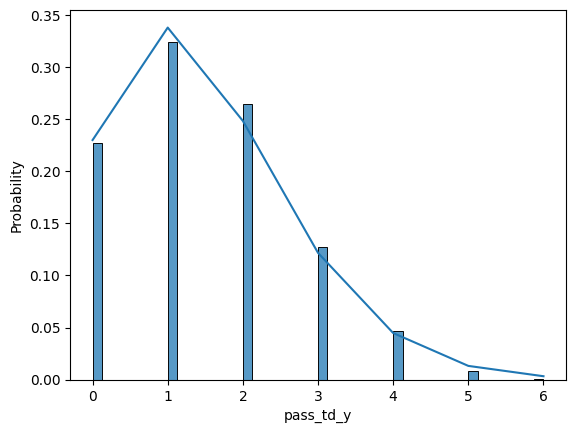

In [7]:
pass_td_y_mean_py =\
    pbp_py_pass_td_y\
    .pass_td_y\
    .mean()

plot_pos_py =\
    pd.DataFrame(
        {"x": range(0, 7),
        "expected": [poisson.pmf(x, pass_td_y_mean_py) for x in range(0, 7)]
        }
    )

sns.histplot(pbp_py_pass_td_y["pass_td_y"], stat="probability");
plt.plot(plot_pos_py.x, plot_pos_py.expected);
plt.show();

Histogram (vertical bars) of normalized observed touchdowns per game per quarterback with
at least 10 games. The term normalized refers to the fact that all of the bars sum to 1. The line shows the
theoretical expected values from the Poisson distribution.

The Poisson distribution seems to slightly overestimate the likelihood of one
touchdown pass, and as such slightly underestimate the likelihood of zero, two,
or more touchdown passes in a game.

Although not large, such discrepancies can be the difference between winning
and losing in sports betting, so if you actually want to wager on your opinions
some adjustments need to be made-or a different distribution entirely (such as a
negative Binomial distribution or quasi-Poisson that accounts for over-
dispersion) should be used.